In [ ]:
#!pip install sympy
#!pip install numpy
#!pip install scipy
#!pip install control

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.patches import Ellipse
import sympy as sp
from sympy import Eq, Poly, exp
from sympy import fraction
from sympy.abc import s,t
import numpy as np
import scipy as scp
from scipy import signal
from scipy.signal import residue
from control import tf
from scipy.stats import pearsonr
import scipy.signal as signal
import random
import warnings
warnings.simplefilter("ignore", np.ComplexWarning)

In [12]:
# Symbolic variables declaration
Vo, Vi              = sp.symbols('Vo Vi')
CC0, C1, C2, C3, C4 = sp.symbols('CC0 C1 C2 C3 C4')
RL                  = sp.symbols('RL') 
L1, L2, L3          = sp.symbols('L1 L2 L3')
I1, I2, I3, I4, I5  = sp.symbols('I1 I2 I3 I4 I5')

# Time range for plotting: 400 points spaced by 25 ns
time_vector = np.arange(0, 2500) * 0.1 * 10**-9  

# Data storage for plots and analysis
output_values           = []  # Summed graphs with errors
freq_response_component = []  # Frequency response terms for plotting
auxiliary_values        = []  # Auxiliary data storage
oscillation_count       = 0  # Counter for sine/cosine repetition

# Statistical properties
mean_values             = []  # Mean of all y values
std_dev_values          = []  # Standard deviation of y and mean values

# Real and imaginary parts for pole mapping
real_part_poles         = []
imaginary_part_poles    = []

# Laplace Transform function
def laplace_transform(f):
    return sp.laplace_transform(f, t, s, noconds=True)

# Circuit equations
eq1 = Eq(I1 / (CC0 * s) + (I1 - I2) / (C1 * s), Vi)
eq2 = Eq((I2 - I3) / (C2 * s) - (I1 - I2) / (C1 * s) + L1 * s * I2, 0)
eq3 = Eq((I3 - I4) / (C3 * s) - (I2 - I3) / (C2 * s) + L2 * s * I3, 0)
eq4 = Eq((I4 - I5) / (C4 * s) - (I3 - I4) / (C3 * s) + L3 * s * I4, 0)
eq5 = Eq(I5 * RL - (I4 - I5) / (C4 * s), 0)
eq6 = Eq(I5 * RL, Vo)

# Solve the system for currents and output voltage
equations = [eq1, eq2, eq3, eq4, eq5, eq6]
solution = sp.solve(equations, (I1, I2, I3, I4, I5, Vo)) 

# Extracting current I5
S_I5 = solution[I5]  

# Transfer function: output divided by input
transfer_function = (RL * S_I5) / Vi

In [ ]:
# Number of Monte Carlo iterations
num_iterations = 1000

# Circuit components
component_list = [CC0, C1, C2, C3, C4, L1, L2, L3, RL]

# Values assigned to components
component_values = [
    101e-9, 230.1e-12, 138e-12, 102e-12, 6.8e-12,  # Capacitors
    2.48e-6, 1.6e-6, 0.78e-6,  # Inductors
    112.16  # Resistor
]

# Component tolerances (percentage variations)
component_tolerances = 10*[
    0.0505, 0.0105, 0.0105, 0.0102, 0.015,  # Capacitors
    0.02, 0.02, 0.02,   # Inductors
    0.01    # Resistor
]

# Data storage for Monte Carlo analysis
monte_carlo_results = []
output_signals      = []
min_values          = []
fwhm_values         = []
all_poles           = []
amplitude_values    = []

for i in range(num_iterations):

    # Component values with random variations
    component_values_varied = []
    
    for value, tolerances in zip(component_values, component_tolerances):
        variation = random.gauss(0, tolerances) if tolerances != 0 else 0
        new_value = value * (1 + variation)
        component_values_varied.append(new_value)

    # Ensure first iteration uses base values
    if i == 0:
        component_values_varied = component_values
    
    # Store modified component values
    monte_carlo_results.append(component_values_varied)

    # Transfer function from previously computed equation
    transfer_function_varied = transfer_function

    # Substitute varied component values into the transfer function
    for variable, value in zip(component_list, component_values_varied):
        transfer_function_varied = transfer_function_varied.subs(variable, value)

    # Extract numerator and denominator
    numerator, denominator = fraction(transfer_function_varied)

    # Compute numerator and denominator coefficients
    num_coeffs = sp.Poly(numerator, s).all_coeffs()
    den_coeffs = sp.Poly(denominator, s).all_coeffs()

    # Compute poles and residues using partial fraction expansion
    residues, poles, b0 = [],[],[]
    residues, poles, b0 = signal.residue(num_coeffs, den_coeffs)

    # Store all poles, separating real and complex values
    temp_poles = []
    for k in range(len(poles)):
        if poles[k].imag == 0:
            temp_poles.append(poles[k])
    for k in range(len(poles)):
        if poles[k].imag != 0:
            temp_poles.append(poles[k])

    all_poles.append(temp_poles)

    # Remove imaginary part from real residues
    for k in range(len(poles)):
        if poles[k].imag == 0:
            residues[k] = residues[k].real

    # Compute inverse Laplace transform components
    signal_components = []

    for k in range(len(poles)):
        if poles[k].imag == 0:
            # Exponential terms
            gain = residues[k]
            decay_rate = poles[k]
            signal_component = gain * np.exp(decay_rate * time_vector)
            signal_components.append(signal_component)
        else:
            # Sinusoidal components
            pole = poles[k]
            previous_pole = poles[k-1]

            if pole != previous_pole and pole != np.conjugate(previous_pole):
                res = residues[k]
                real_part = pole.real
                imag_part = abs(pole.imag)
                magnitude = abs(res)
                phase = np.angle(res)

                # Compute frequency component
                signal_component = (
                    2 * magnitude * np.exp(real_part * time_vector) *
                    np.cos(imag_part * time_vector + phase)
                )
                signal_components.append(signal_component)

    # Sum signal components
    signal = sum(signal_components).real

    # Normalize the signal
    max_signal_value = max(abs(signal))
    normalized_signal = signal / max_signal_value

    # Compute FWHM (Full Width at Half Maximum)
    max_value = np.max(normalized_signal)
    half_max_level = max_value / 2
    crossings = np.where(np.diff(np.sign(normalized_signal - half_max_level)))[0]

    if len(crossings) >= 2:
        fwhm = crossings[-1] - crossings[0]
    else:
        fwhm = np.nan  # If signal does not cross half max

    # Compute minimum value in the signal
    min_index = np.argmin(normalized_signal)
    min_value = normalized_signal[min_index]

    # Store results
    output_signals.append(normalized_signal)
    min_values.append(min_value)
    fwhm_values.append(fwhm)
    amplitude_values.append(max(normalized_signal))

# Histogram for FWHM values
plt.hist(fwhm_values, bins=30, color='blue', edgecolor='black')
plt.xlabel("Full Width at Half Maximum (FWHM)")
plt.ylabel("Frequency")
plt.title("Histogram of FWHM")
plt.grid(True)
plt.show()

# Histogram for minimum values
plt.hist(min_values, bins=30, color='red', edgecolor='black')
plt.xlabel("Minimum Signal Value")
plt.ylabel("Frequency")
plt.title("Histogram of Minimum Values")
plt.grid(True)
plt.show()


AttributeError: 'numpy.ndarray' object has no attribute 'residue'

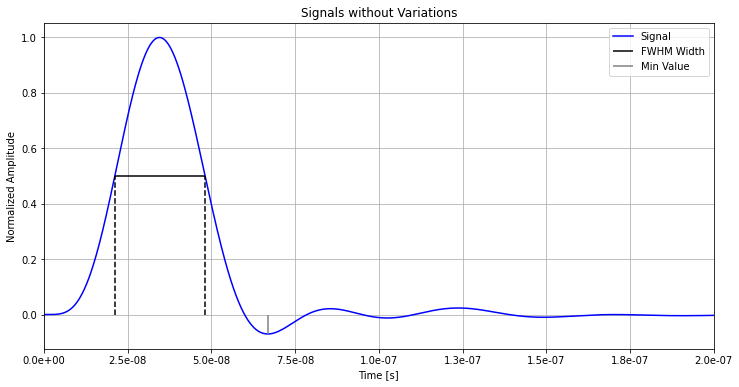

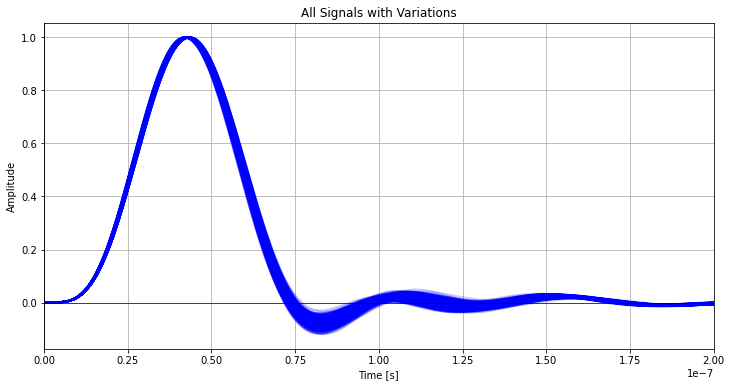

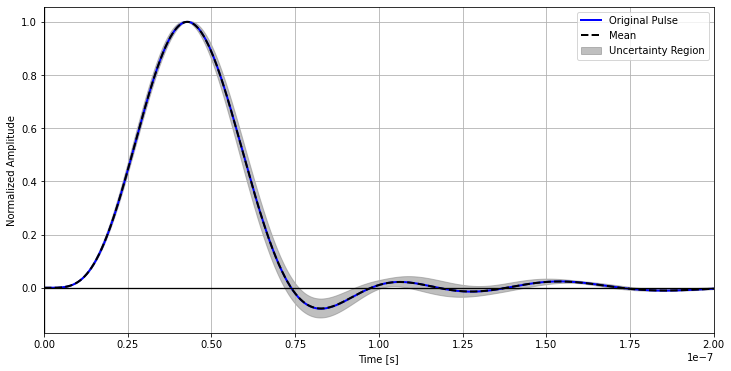

In [62]:
# Plot the signal and highlight key measurements
plt.figure(figsize=(12, 6))
plt.plot(normalized_signal, label="Signal", color='blue')

# Highlight crossings at half maximum
if len(crossings) >= 2:
    plt.vlines(crossings[0], 0, half_max_level, color='black', linestyle='dashed')
    plt.vlines(crossings[-1], 0, half_max_level, color='black', linestyle='dashed')
    plt.hlines(half_max_level, crossings[0], crossings[-1], 
               colors='black', linestyles='solid', label="FWHM Width")

# Mark the minimum point with a vertical line
plt.vlines(min_index, min_value, 0, color='grey', linestyle='solid', label="Min Value")

# Configure X-axis labels to reflect time in nanoseconds
plt.xlim(0, 2000)
custom_ticks = np.linspace(0, len(normalized_signal), 9)  # Define positions for X-axis labels
custom_labels = [f"{tick / 25  * 2e-9:.1e}" for tick in custom_ticks]  # Convert to nanoseconds

plt.xticks(custom_ticks, custom_labels)  # Update X-axis labels

plt.xlabel("Time [s]")
plt.ylabel("Normalized Amplitude")
plt.title("Signals without Variations")
plt.legend()
plt.grid()

plt.show()


# Plot all signals with variations
plt.figure(figsize=(12, 6))
for i in range(num_iterations):
    plt.plot(time_vector, output_signals[i], color='b', linewidth=2, alpha=0.2)  # Add transparency for readability

plt.axhline(0, color='black', linewidth=0.65)
plt.axvline(0, color='black', linewidth=0.65)
plt.xlim(0, 2e-7)
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.title("All Signals with Variations")
plt.grid(True)
plt.show()


# Compute the mean of the list (without normalization)
mean_signal = np.mean(output_signals, axis=0)

# Compute the standard deviation
std_dev = np.std(output_signals, axis=0)

# Compute confidence bands (±2.5 standard deviations)
upper_band = mean_signal + 2.5 * std_dev
lower_band = mean_signal - 2.5 * std_dev

# Plot the mean signal with confidence bands
plt.figure(figsize=(12, 6))
plt.plot(time_vector, output_signals[0], label='Original Pulse', linestyle='-', color='b', linewidth=2)
plt.plot(time_vector, mean_signal, label='Mean', linestyle='--', color='black', linewidth=2)

# Fill between the confidence bands
plt.fill_between(time_vector, upper_band, lower_band, color='gray', alpha=0.5, label="Uncertainty Region")

# Axes configuration
plt.axhline(0, color='black', linewidth=1.3)
plt.axvline(0, color='black', linewidth=1.3)

plt.xlim(0, 2e-7)
plt.xlabel("Time [s]")
plt.ylabel("Normalized Amplitude")
plt.legend()
plt.grid()
plt.show()



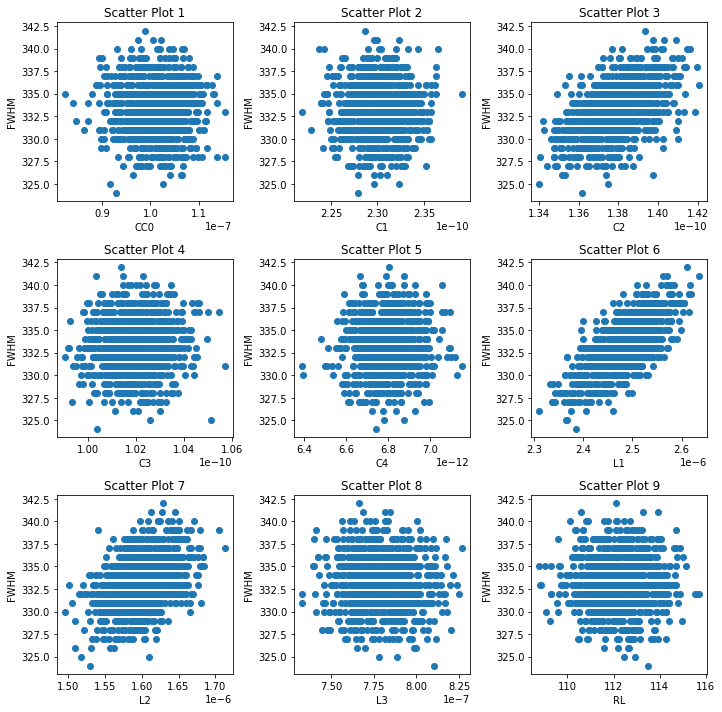

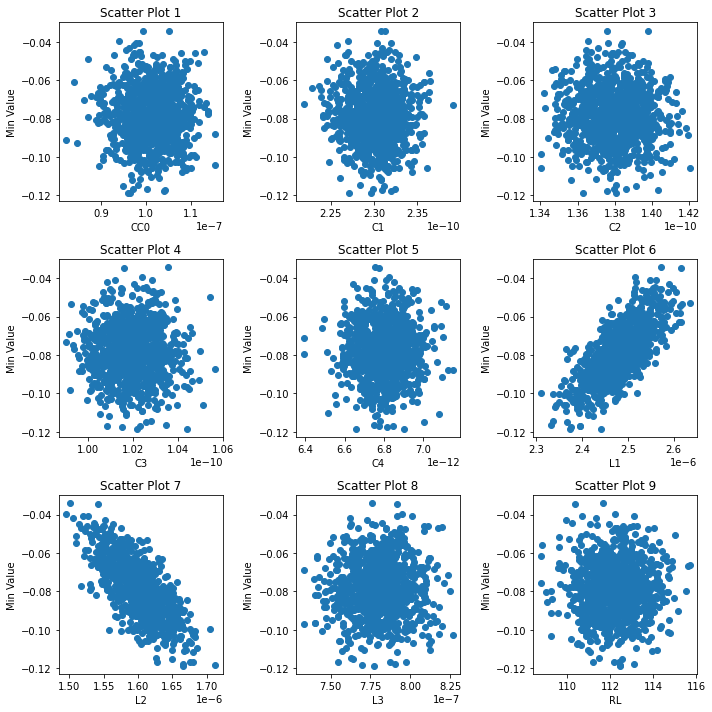

In [33]:
# Group values by component for later graphical representation
x_coords = [[] for _ in range(9)]  # List to store x-coordinates for each component
y_coords_fwhm = []  # Stores FWHM values
y_coords_min = []  # Stores Min Value

# Populate x and y coordinate lists
for i, component_set in enumerate(monte_carlo_results):
    for j in range(9):
        x_coords[j].append(component_set[j])

    y_coords_fwhm.append(fwhm_values[i])
    y_coords_min.append(min_values[i])

# Component labels
component_labels = ["CC0", "C1", "C2", "C3", "C4", "L1", "L2", "L3", "RL"]

# Scatter plots for FWHM
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for index, ax in enumerate(axs.flat):
    ax.scatter(x_coords[index], y_coords_fwhm)
    ax.set_title(f"Scatter Plot {index+1}")
    ax.set_xlabel(component_labels[index])
    ax.set_ylabel("FWHM")

plt.tight_layout()
plt.show()

# Scatter plots for Minimum Value
fig, axs = plt.subplots(3, 3, figsize=(10, 10))

for index, ax in enumerate(axs.flat):
    ax.scatter(x_coords[index], y_coords_min)
    ax.set_title(f"Scatter Plot {index+1}")
    ax.set_xlabel(component_labels[index])
    ax.set_ylabel("Min Value")

plt.tight_layout()
plt.show()


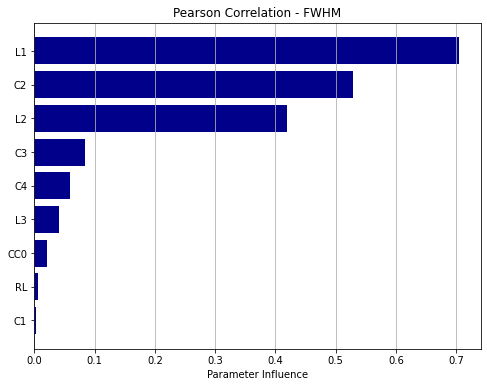

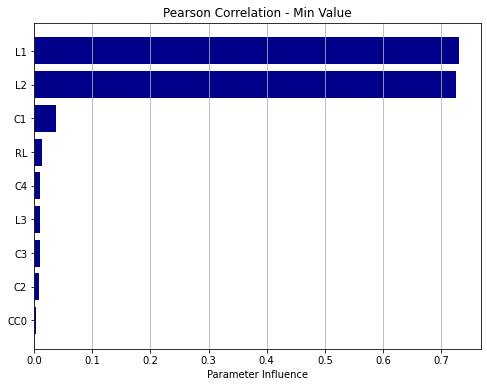

In [34]:
# Compute Pearson correlation for each component with FWHM
pearson_fwhm = {label: abs(pearsonr(x_coords[i], y_coords_fwhm)[0]) for i, label in enumerate(component_labels)}
sorted_labels_fwhm = sorted(pearson_fwhm, key=pearson_fwhm.get)
sorted_values_fwhm = [pearson_fwhm[label] for label in sorted_labels_fwhm]

# Plot Pearson correlation for FWHM
plt.figure(figsize=(8, 6))
plt.barh(sorted_labels_fwhm, sorted_values_fwhm, color='darkblue')
plt.xlabel('Parameter Influence')
plt.title('Pearson Correlation - FWHM')
plt.grid(axis='x')
plt.show()

# Compute Pearson correlation for each component with Min Value
pearson_min_value = {label: abs(pearsonr(x_coords[i], y_coords_min)[0]) for i, label in enumerate(component_labels)}
sorted_labels_min = sorted(pearson_min_value, key=pearson_min_value.get)
sorted_values_min = [pearson_min_value[label] for label in sorted_labels_min]

# Plot Pearson correlation for Min Value
plt.figure(figsize=(8, 6))
plt.barh(sorted_labels_min, sorted_values_min, color='darkblue')
plt.xlabel('Parameter Influence')
plt.title('Pearson Correlation - Min Value')
plt.grid(axis='x')
plt.show()
